In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [118]:
headers = [
    "ID",                   # Sample code number
    "Diagnosis",            # Diagnosis (M = malignant, B = benign)
    "Radius Mean",          # Mean of distances from center to points on the perimeter
    "Texture Mean",         # Standard deviation of gray-scale values
    "Perimeter Mean",       # Mean size of the core tumor perimeter
    "Area Mean",            # Mean size of the core tumor area
    "Smoothness Mean",      # Mean of local variation in radius lengths
    "Compactness Mean",     # Mean of perimeter^2 / area - 1.0
    "Concavity Mean",       # Mean of severity of concave portions of the contour
    "Concave Points Mean",  # Mean for number of concave portions of the contour
    "Symmetry Mean",        # Mean of symmetry
    "Fractal Dimension Mean", # Mean for "coastline approximation" - 1
    "Radius SE",            # Standard error of distances from center to points on the perimeter
    "Texture SE",           # Standard error of gray-scale values
    "Perimeter SE",         # Standard error of tumor perimeter
    "Area SE",              # Standard error of tumor area
    "Smoothness SE",        # Standard error of local variation in radius lengths
    "Compactness SE",       # Standard error of perimeter^2 / area - 1.0
    "Concavity SE",         # Standard error of concave portions of the contour
    "Concave Points SE",    # Standard error for number of concave portions of the contour
    "Symmetry SE",          # Standard error of symmetry
    "Fractal Dimension SE", # Standard error for "coastline approximation" - 1
    "Radius Worst",         # Worst (largest) value for radius
    "Texture Worst",        # Worst value for gray-scale values
    "Perimeter Worst",      # Worst value for tumor perimeter
    "Area Worst",           # Worst value for tumor area
    "Smoothness Worst",     # Worst value for local variation in radius lengths
    "Compactness Worst",    # Worst value for perimeter^2 / area - 1.0
    "Concavity Worst",      # Worst value for concave portions of the contour
    "Concave Points Worst", # Worst value for number of concave portions of the contour
    "Symmetry Worst",       # Worst value for symmetry
    "Fractal Dimension Worst" # Worst value for "coastline approximation" - 1
]

data = pd.read_csv('bcancer_data/wdbc.data', header = None, names = headers)
data.head

<bound method NDFrame.head of            ID Diagnosis  Radius Mean  Texture Mean  Perimeter Mean  Area Mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0  

In [125]:
X = data.iloc[:, 2:]  # features
y = LabelEncoder().fit_transform(data['Diagnosis'])  # M = 1, B = 0

# standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# partitions for training and testing
partitions = [0.8, 0.5, 0.2]  # training sizes: 80%, 50%, 20%

# classifiers to evaluate
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42)
}

# store results
results = {}

# iterate over partitions
for train_size in partitions:
    test_size = 1 - train_size
    print(f"\nPartition: {int(train_size*100)}% Training, {int(test_size*100)}% Testing")
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    # evaluate each classifier
    for clf_name, clf in classifiers.items():
        print(f"\nClassifier: {clf_name}")
        
        # hyperparameter tuning for each classifier
        if clf_name == 'RandomForest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        elif clf_name == 'LogisticRegression':
            param_grid = {
                'C': [0.01, 0.1, 1, 10],
                'penalty': ['l2']
            }
        elif clf_name == 'SVM':
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto']
            }
        else:
            param_grid = {}

        # perform grid search with cross-validation
        grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        # best estimator and performance on test data
        best_clf = grid_search.best_estimator_
        y_pred = best_clf.predict(X_test)
        
        # store results
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        
        # save results for this partition and classifier
        results[(clf_name, train_size)] = {
            'best_params': grid_search.best_params_,
            'accuracy': accuracy,
            'classification_report': classification_report(y_test, y_pred, output_dict=True)
        }

results_with_string_keys = {
    f"{key[0]}_{int(key[1] * 100)}%": value
    for key, value in results.items()
}

# Save to a JSON file
output_file = "breast_cancer_results.json"
with open(output_file, "w") as file:
    json.dump(results_with_string_keys, file, indent=4)

print(f"Results saved to {output_file}")



Partition: 80% Training, 19% Testing

Classifier: RandomForest
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9649
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Classifier: LogisticRegression
Best Parameters: {'C': 1, 'penalty': 'l2'}
Accuracy: 0.9737
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Classifier: SVM
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy

/var/folders/c1/tcshx8gx5qjfjjxf4cwhb_gc0000gn/T/ipykernel_22557/1552216024.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  high_corr = numeric_data.corr().applymap(lambda x: x if abs(x) > 0.5 else 0)


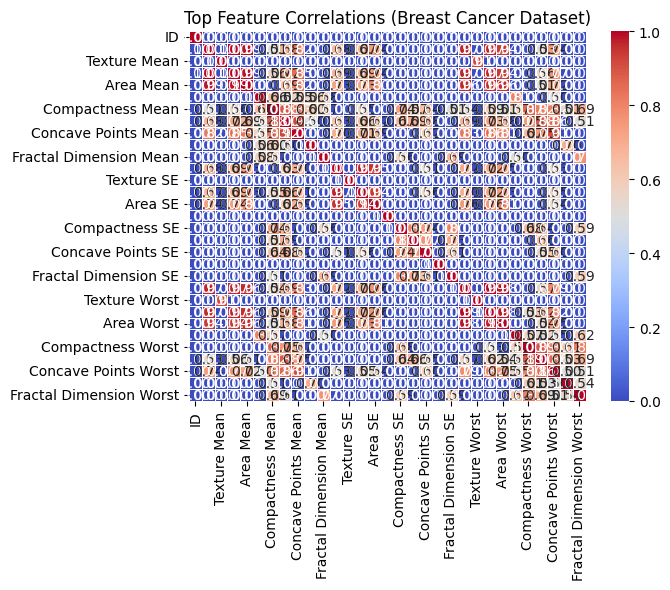

In [120]:
high_corr = numeric_data.corr().applymap(lambda x: x if abs(x) > 0.5 else 0)

sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Top Feature Correlations (Breast Cancer Dataset)")
plt.show()